# 1. Decision trees model

### Importing libraries and dataset

In [50]:
# Importing libraries
import numpy as np
import pandas as pd

# For splitting dataset
from sklearn.model_selection import train_test_split, GridSearchCV

# For decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Evaluation tools
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay, classification_report

# For visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_graphviz
from IPython.display import Image  
from subprocess import call

import os

In [51]:
# Importing dataset
titanic_df = pd.read_csv("titanic.csv")
titanic_df.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [52]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [53]:
# Dropping columns that don't help with predicting passenger survival
titanic_df.drop(["Cabin", "Name", "Ticket"], axis=1, inplace=True)

In [54]:
# Dealing with null values
titanic_df["Age"].fillna((titanic_df["Age"].mean()), inplace=True)

C:\Users\amylo\AppData\Local\Temp\ipykernel_25588\2377218018.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  titanic_df["Age"].fillna((titanic_df["Age"].mean()), inplace=True)


### One-Hot Encoding
One-hot encoding is a technique used to ensure that categorical variables are better represented in the machine. Let's take a look at the "Sex" column

In [55]:
titanic_df["Sex"].unique()

array(['male', 'female'], dtype=object)

Machine Learning classifiers don't know how to handle strings. As a result, you need to convert it into a categorical representation. There are two main ways to go about this:

Label Encoding: Assigning, for example, 0 for "male" and 1 for "female". The problem here is it intrinsically makes one category "larger than" the other category.

One-hot encoding: Assigning, for example, [1, 0] for "male" and [0, 1] for female. In this case, you have an array of size (n_categories,) and you represent a 1 in the correct index, and 0 elsewhere. In Pandas, this would show as extra columns. For example, rather than having a "Sex" column, it would be a "Sex_male" and "Sex_female" column. Then, if the person is male, it would simply show as a 1 in the "Sex_male" column and a 0 in the "Sex_female" column.

There is a nice and easy method that does this in pandas: get_dummies()

In [56]:
# One-hot encoding to change categorical data into numerical data
# One-hot encoding 'Sex' column
titanic_df = pd.get_dummies(titanic_df, prefix="Sex", columns=["Sex"])
titanic_df.head()

PassengerId  Survived  Pclass   Age  SibSp  Parch     Fare Embarked  \
0            1         0       3  22.0      1      0   7.2500        S   
1            2         1       1  38.0      1      0  71.2833        C   
2            3         1       3  26.0      0      0   7.9250        S   
3            4         1       1  35.0      1      0  53.1000        S   
4            5         0       3  35.0      0      0   8.0500        S   

   Sex_female  Sex_male  
0       False      True  
1        True     False  
2        True     False  
3        True     False  
4       False      True

Now, we do the same to the "Embarked" column.

In [57]:
# One-hot encoding 'Embarked' column
titanic_df = pd.get_dummies(titanic_df, prefix="Embarked", columns=["Embarked"])
titanic_df.head()

PassengerId  Survived  Pclass   Age  SibSp  Parch     Fare  Sex_female  \
0            1         0       3  22.0      1      0   7.2500       False   
1            2         1       1  38.0      1      0  71.2833        True   
2            3         1       3  26.0      0      0   7.9250        True   
3            4         1       1  35.0      1      0  53.1000        True   
4            5         0       3  35.0      0      0   8.0500       False   

   Sex_male  Embarked_C  Embarked_Q  Embarked_S  
0      True       False       False        True  
1     False        True       False       False  
2     False       False       False        True  
3     False       False       False        True  
4      True       False       False        True

### Selecting variables

Splitting in training, development and test sets

In [58]:
# Selecting x and y variables
X = titanic_df.drop("Survived", axis=1)
y = titanic_df["Survived"]

# Creating variable for random state value
r = 42

# Split original dataset into training and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=r)

# Split training set further into training and development sets
X_train, X_dev, y_train, y_dev = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=r)

### Training a model

#### Model without pruning first

In [59]:
# Training model without pruning
unpruned = DecisionTreeClassifier(max_depth=None, random_state=r)
unpruned.fit(X_train, y_train)

print("Performance without pruning:", unpruned.score(X_test, y_test))
print("At depth:", unpruned.tree_.max_depth)

Performance without pruning: 0.7597765363128491
At depth: 16


In [60]:
# Training model without pruning on development data
unpruned_dev = DecisionTreeClassifier(max_depth=None, random_state=r)
unpruned_dev.fit(X_dev, y_dev)

print("Performance without pruning:", unpruned_dev.score(X_test, y_test))
print("At depth:", unpruned_dev.tree_.max_depth)

Performance without pruning: 0.6983240223463687
At depth: 14


GridSearchCV to optimise hyperparameters

In [61]:
# Define parameter grid for GridSearchCV
param_grid = {
'criterion': ['gini', 'entropy'],
'max_depth': [None, 5, 10, 15],
'min_samples_split': [2, 5, 10],
'min_samples_leaf': [1, 2, 4]
} 

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=unpruned_dev, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform Grid Search Cross Validation
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate the best model on test data
best_model = grid_search.best_estimator_
best_accuracy = accuracy_score(y_test, best_model.predict(X_test))
print("Best Model Accuracy:", best_accuracy)

Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best Score: 0.8067380841484241
Best Model Accuracy: 0.7932960893854749


Plotting tree at full depth before pruning

In [62]:
graphviz_installed = True

if (graphviz_installed):
  export_graphviz(unpruned, out_file='unpruned_tree.dot', feature_names = X_train.columns,
                  rounded = True, proportion = False, precision = 2, filled = True)
  
  # Convert to png using system command
  call(['dot', '-Tpng', 'pruned_tree.dot', '-o', 'unpruned_tree.png', '-Gdpi=600'])
  
else: 
  fig = plt.figure()
  tree.plot_tree(unpruned,feature_names = X_train.columns, 
                     rounded = True, proportion = False, precision = 2, filled = True) # Display tree
  fig.savefig('pruned_tree.png')

Image(filename = 'pruned_tree.png', width=2000)

#### Model with pruning now

Model with pruning to see impacts on performance

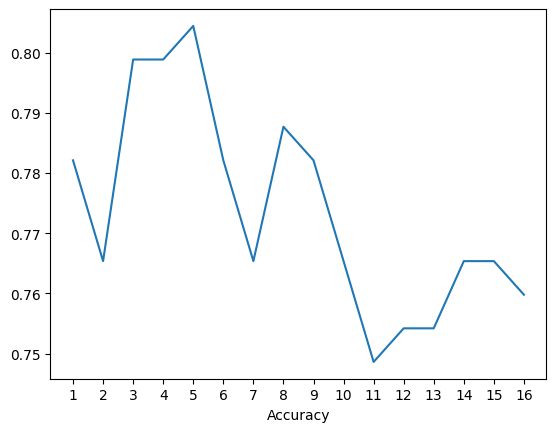

In [63]:
# Looking at effects of pruning   
pruned_depths = range(1,unpruned.tree_.max_depth+1) # +1 or else it won't include the whole range

pruned_scores = []
# For loop to calculate and store pruned decision tree scores
for d in pruned_depths:
  clf = DecisionTreeClassifier(max_depth=d, random_state=r)
  clf.fit(X_train, y_train)
  score = clf.score(X_test, y_test)
  pruned_scores.append(score)

# Plotting pruned scores to see impact on model performance
fig, ax = plt.subplots()
ax.plot(pruned_depths, pruned_scores)
plt.xlabel("Max_depth values")
plt.xlabel("Accuracy")
ax.xaxis.set_ticks(pruned_depths)
plt.show()

The best model depth appears is 5 for performance

In [65]:
# Fitting the chosen tree with optimal depth for accuracy
best_depth = pruned_depths[np.argmax(pruned_scores)]
print("Best performance reached at depth of:", best_depth)

pruned = DecisionTreeClassifier(max_depth=best_depth)
pruned.fit(X, y)
print("Performance with pruning:", pruned.score(X_test, y_test))

Best performance reached at depth of: 5
Performance with pruning: 0.8491620111731844


Comparing pruned and unpruned scores

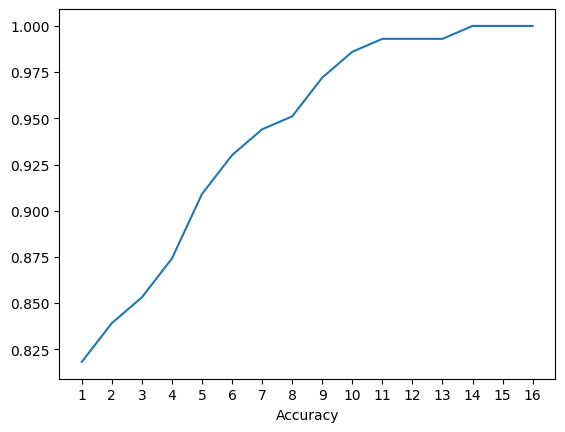

In [66]:
# Calculating and storing decision tree accuracy on development dataset
pruned_dev_depths = range(1,unpruned.tree_.max_depth+1) # +1 or else it won't include the whole range

pruned_dev_scores = []
# For loop to calculate and store pruned decision tree scores for development set
for d in pruned_dev_depths:
  clf = DecisionTreeClassifier(max_depth=d, random_state=r)
  clf.fit(X_dev, y_dev)
  score = clf.score(X_dev, y_dev)
  pruned_dev_scores.append(score)

# Plotting pruned scores for development set to see impact on model performance
fig, ax = plt.subplots()
ax.plot(pruned_dev_depths, pruned_dev_scores)
plt.xlabel("Max_depth values")
plt.xlabel("Accuracy")
ax.xaxis.set_ticks(pruned_dev_depths)
plt.show()

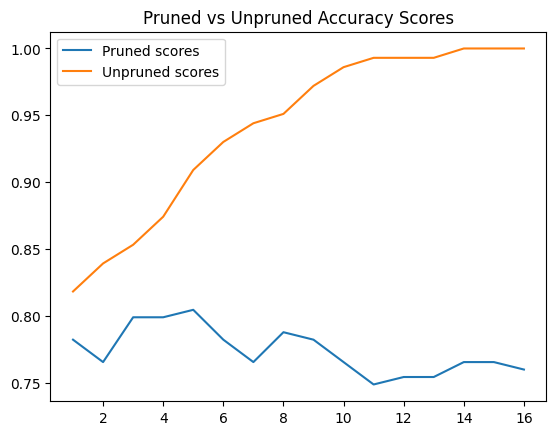

In [67]:
# Plotting pruned vs unpruned accuracy scores
plt.plot(pruned_depths, pruned_scores, label="Pruned scores")
plt.plot(pruned_dev_depths, pruned_dev_scores, label="Unpruned scores")
plt.title("Pruned vs Unpruned Accuracy Scores")
plt.legend()

*The shape of these two plots shows that the unpruned scores may be overfit?*

Final model accuracy

In [68]:
print("Final model accuracy=", pruned.score(X_test, y_test))

Final model accuracy= 0.8491620111731844


Plotting chosen tree (with pruning)

In [69]:
graphviz_installed = True

if (graphviz_installed):
  export_graphviz(pruned, out_file='pruned_tree.dot', feature_names = X_train.columns,
                  rounded = True, proportion = False, precision = 2, filled = True)
  
  # Convert to png using system command
  call(['dot', '-Tpng', 'pruned_tree.dot', '-o', 'pruned_tree.png', '-Gdpi=600'])
  
else: 
  fig = plt.figure()
  tree.plot_tree(pruned,feature_names = X_train.columns, 
                     rounded = True, proportion = False, precision = 2, filled = True) # Display tree
  fig.savefig('pruned_tree.png')

Image(filename = 'pruned_tree.png', width=2000)